In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchvision
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.image_classification.models.res2net import Res2Net
from torchvision import transforms

# Setting

In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 16

In [4]:
artifact_path = Path("../../artifacts/res2net")
data_path = Path("../../data/animal10")

In [5]:
device = torch.device("cuda:0")

# data

In [6]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [7]:
dataset = torchvision.datasets.ImageFolder(
    data_path.as_posix(),
    transform=preprocess,
)

In [8]:
train_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [9]:
num_class = len(dataset.classes)

In [10]:
dataset.classes

['cane',
 'cavallo',
 'elefante',
 'farfalla',
 'gallina',
 'gatto',
 'mucca',
 'pecora',
 'ragno',
 'scoiattolo']

In [11]:
len(dataset)

26179

pecora


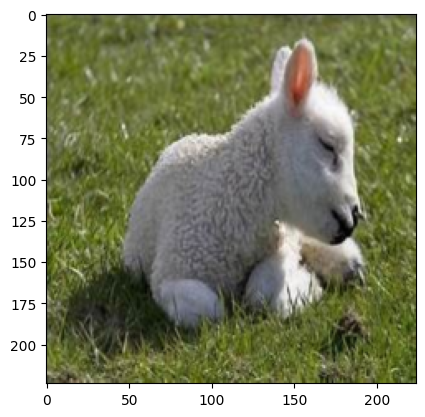

In [12]:
import random
demo_img, demo_label = dataset[random.randint(0, len(dataset))]
print(dataset.classes[demo_label])
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [13]:
model = Res2Net(output_size=num_class, key=50, groups=4).to(device)

In [14]:
torchinfo.summary(model)

Layer (type:depth-idx)                                            Param #
Res2Net                                                           --
├─Sequential: 1-1                                                 --
│    └─Conv2dNormActivation: 2-1                                  --
│    │    └─Conv2d: 3-1                                           9,408
│    │    └─BatchNorm2d: 3-2                                      128
│    │    └─ReLU: 3-3                                             --
│    └─MaxPool2d: 2-2                                             --
├─Sequential: 1-2                                                 --
│    └─ResBlock: 2-3                                              --
│    │    └─ReLU: 3-4                                             --
│    │    └─BottleNeck: 3-5                                       21,728
│    │    └─Sequential: 3-6                                       16,896
│    └─ResBlock: 2-4                                              --
│    │    └─ReLU:

# training

In [15]:
epoches = 10
acc_iters = 64 // BATCH_SIZE

In [16]:
trainer = ClassificationTrainer(epoches, device, acc_iters)

In [17]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters(), weight_decay=1e-5)

In [18]:
training_loss = trainer.run(train_loader, model, optim, criterion)

  0%|          | 0/1636 [00:00<?, ?it/s]

100%|██████████| 1636/1636 [16:11<00:00,  1.68it/s]


epoch 1 : 0.02714177606625068


100%|██████████| 1636/1636 [02:44<00:00,  9.96it/s]


epoch 2 : 0.01990290198812129


100%|██████████| 1636/1636 [02:43<00:00, 10.00it/s]


epoch 3 : 0.01720783897945407


100%|██████████| 1636/1636 [02:45<00:00,  9.90it/s]


epoch 4 : 0.015275244339207565


100%|██████████| 1636/1636 [02:44<00:00,  9.92it/s]


epoch 5 : 0.013766086089918913


100%|██████████| 1636/1636 [02:43<00:00, 10.00it/s]


epoch 6 : 0.012559576372617131


100%|██████████| 1636/1636 [02:44<00:00,  9.98it/s]


epoch 7 : 0.011583522908574012


100%|██████████| 1636/1636 [02:43<00:00,  9.99it/s]


epoch 8 : 0.010271967957032535


100%|██████████| 1636/1636 [02:43<00:00, 10.01it/s]


epoch 9 : 0.009570339446489455


100%|██████████| 1636/1636 [02:43<00:00,  9.98it/s]

epoch 10 : 0.008800845911079097


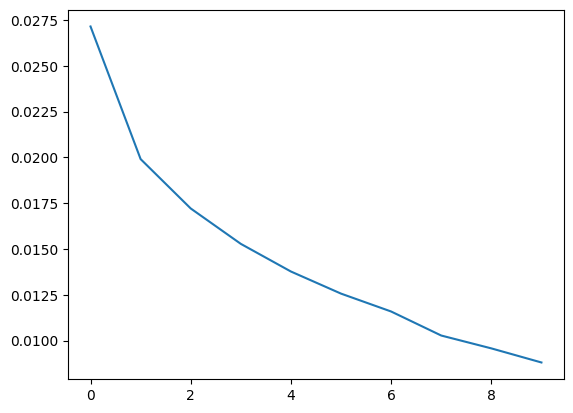

In [19]:
plt.plot(training_loss)

# inference

In [20]:
test_preprocess = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [21]:
test_dataset = torchvision.datasets.ImageFolder(
    data_path.as_posix(),
    transform=test_preprocess,
)

In [22]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [23]:
evaluator = ClassificationEvaluator(num_class, device)

In [24]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 1637/1637 [02:05<00:00, 13.08it/s]

[[3969   54   32   12   39   77  283   84  185  128]
 [ 155 1784   22    7   15   12  475   48   82   23]
 [  42   37 1185    3    7    3   72   44   31   22]
 [  15    3    4 1549   26    9    8    6  462   30]
 [ 118    6   10   23 2631   16   36   43  160   55]
 [ 284    2    7   10   15 1029   24   42  107  148]
 [  51   18    9    0    7    3 1691   56   24    7]
 [  65    8   26    1   13    6  307 1333   41   20]
 [  14    1    7   36    6   21    4   16 4673   43]
 [  70    4   16   12   26   17   13   33  177 1494]]


In [25]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(test_dataset.classes, per_class_acc)

cane      : 0.8161628624305984
cavallo   : 0.6801372474266107
elefante  : 0.8195020746887967
farfalla  : 0.7334280303030303
gallina   : 0.8492575855390575
gatto     : 0.6169064748201439
mucca     : 0.9062165058949625
pecora    : 0.7324175824175824
ragno     : 0.9693009749014727
scoiattolo: 0.8023630504833512


In [26]:
per_class_acc.mean()

0.7925692388905607

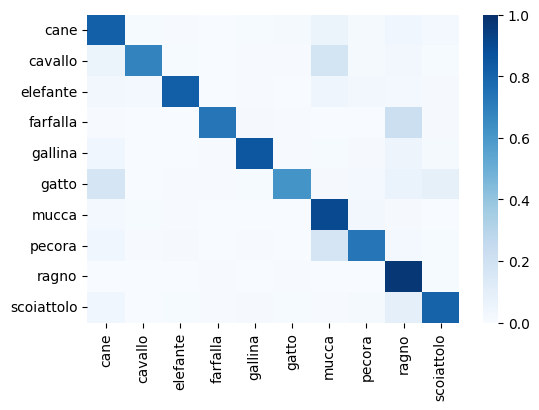

In [27]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    test_dataset.classes,
    "Blues",
    annot=False,
    figsize=(6, 4),
)

In [28]:
model_path = artifact_path / 'res2net50.pth'

In [29]:
torch.save(model.state_dict(), model_path)

In [30]:
get_file_size(model_path)

'47.56MB'

In [31]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>